In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
# from mpl_finance import candlestick_ohlc
import mplfinance as mpf

from binance.client import Client
from config import *

client = Client(api_key, api_secret)

In [2]:
def heikenashi(df):
    do = df.copy()
    do['HA_Close'] = (do['Open'] + do['High'] + do['Low'] + do['Close']) / 4
    do['HA_Open'] = (do['Open'].shift(1) + do['Open'].shift(1)) / 2
    do.iloc[0, do.columns.get_loc("HA_Open")] = (do.iloc[0]['Open'] + do.iloc[0]['Close'])/2
    do['HA_High'] = do[['High', 'Low', 'HA_Open', 'HA_Close']].max(axis=1)
    do['HA_Low'] = do[['High', 'Low', 'HA_Open', 'HA_Close']].min(axis=1)
    do = do.drop(['Open', 'High', 'Low', 'Close'], axis=1)  # remove old columns
    do = do.rename(columns={"HA_Open": "Open", "HA_High": "High", "HA_Low": "Low", "HA_Close": "Close"})#, "Volume": "Volume"})
    do = do[['Open', 'High', 'Low', 'Close']]  # reorder columns
    return do

In [3]:
def heikin_ashi(df):
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['Open', 'High', 'Low', 'Close'])
    
    heikin_ashi_df['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
    
    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['Open'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i-1, 0] + heikin_ashi_df.iat[i-1, 3]) / 2
        
    heikin_ashi_df['High'] = heikin_ashi_df.loc[:, ['Open', 'Close']].join(df['High']).max(axis=1)
    
    heikin_ashi_df['Low'] = heikin_ashi_df.loc[:, ['Open', 'Close']].join(df['Low']).min(axis=1)
    
    return heikin_ashi_df

In [36]:
### OHLCV
L3m = client.futures_historical_klines(
    symbol=f'DOTUSDT',
    interval='1m',
    start_str='12-14-2021 16:00:00',
    # start_str='09-20-2021 08:00:00',
    # end_str='10-03-2021 01:00:00',
    limit=60
)

arr_l = np.array(L3m).astype(np.float64)
index = pd.DatetimeIndex(pd.to_datetime(arr_l[:, 0], unit='ms'))# .tz_localize('UTC').tz_convert('America/Lima')
df_serie = pd.DataFrame(arr_l[:, 4], index=index)
SS = np.array(df_serie[0])
SS.shape

(64,)

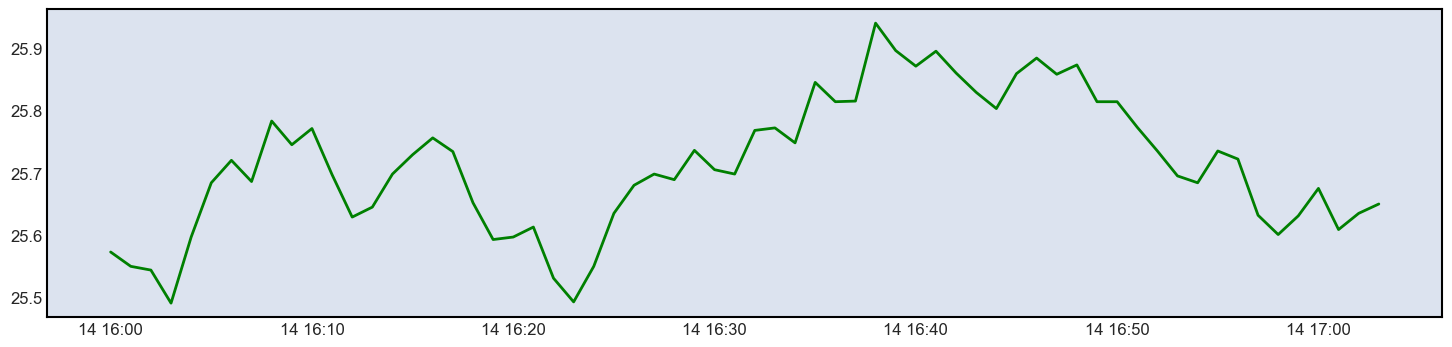

In [37]:
plt.figure(figsize=(18, 4))
# plt.plot(index, SS, ".", c='green')
plt.plot(index, SS, c='green')
plt.grid()
plt.show()

In [38]:
ds = pd.DataFrame(arr_l[:, 1:5], columns=['Open', 'High', 'Low', 'Close'], index=index)
print(ds.shape)
ds.head()

(64, 4)


,Open,High,Low,Close
2021-12-14 16:00:00,25.637,25.652,25.551,25.573
2021-12-14 16:01:00,25.574,25.577,25.517,25.550
2021-12-14 16:02:00,25.552,25.561,25.476,25.544
2021-12-14 16:03:00,25.539,25.539,25.471,25.491
2021-12-14 16:04:00,25.491,25.598,25.470,25.597


In [39]:
de = heikenashi(ds)
print(de.shape)
de.head(3)

(64, 4)


,Open,High,Low,Close
2021-12-14 16:00:00,25.605,25.652,25.551,25.60325
2021-12-14 16:01:00,25.637,25.637,25.517,25.55450
2021-12-14 16:02:00,25.574,25.574,25.476,25.53325


In [40]:
da = heikin_ashi(ds)
da['Open'] = da['Open'].astype(np.float64)
print(da.shape)
da.head(100)

(64, 4)


,Open,High,Low,Close
2021-12-14 16:00:00,25.637000,25.652000,25.551000,25.60325
2021-12-14 16:01:00,25.620125,25.620125,25.517000,25.55450
2021-12-14 16:02:00,25.587313,25.587313,25.476000,25.53325
2021-12-14 16:03:00,25.560281,25.560281,25.471000,25.51000
2021-12-14 16:04:00,25.535141,25.598000,25.470000,25.53900
...,...,...,...,...
2021-12-14 16:59:00,25.658479,25.658479,25.589000,25.61475
2021-12-14 17:00:00,25.636615,25.688000,25.625000,25.65475
2021-12-14 17:01:00,25.645682,25.672000,25.604000,25.63900
2021-12-14 17:02:00,25.642341,25.665000,25.577000,25.62300


In [41]:
da.isna().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

In [42]:
da.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64 entries, 2021-12-14 16:00:00 to 2021-12-14 17:03:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    64 non-null     float64
 1   High    64 non-null     float64
 2   Low     64 non-null     float64
 3   Close   64 non-null     float64
dtypes: float64(4)
memory usage: 4.6 KB


In [43]:
de['side'] = [1 if i else 0 for i in de.Close>de.Open]
# de.head(25)

In [44]:
da['side'] = [1 if i else 0 for i in de.Close>de.Open]
# de.head(25)

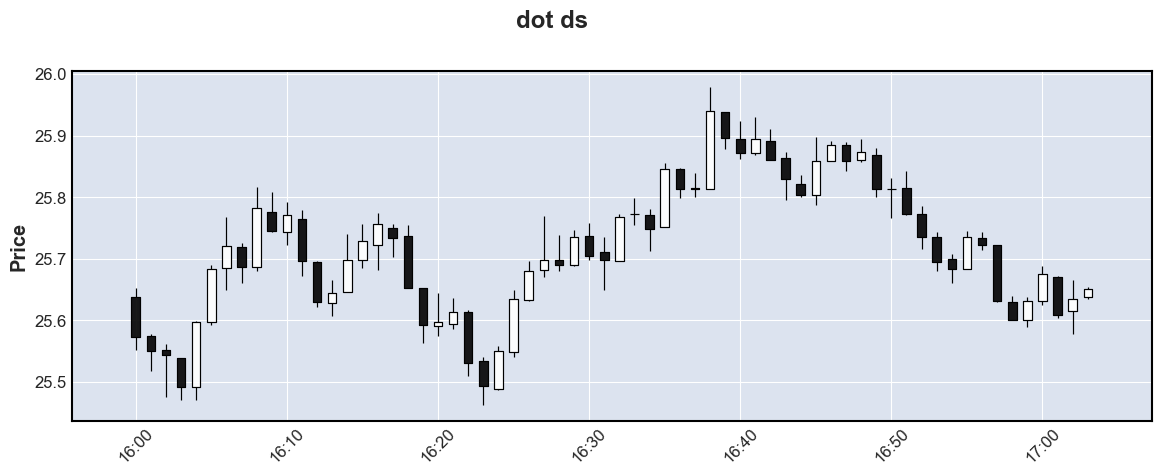

In [45]:
mpf.plot(ds.head(150), type='candle', volume=False, title='dot ds', figsize=(15, 5))

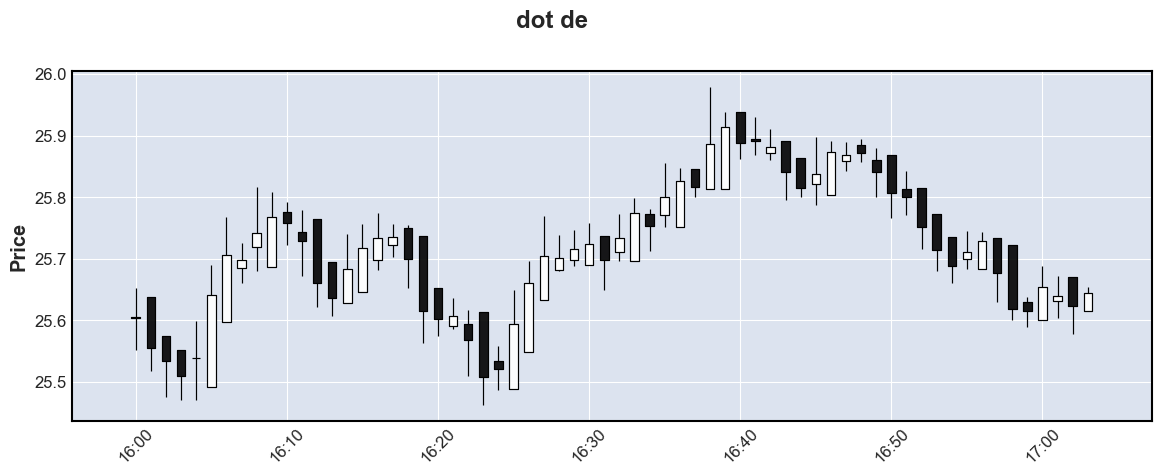

In [46]:
mpf.plot(de.head(150), type='candle', volume=False, title='dot de', figsize=(15, 5))

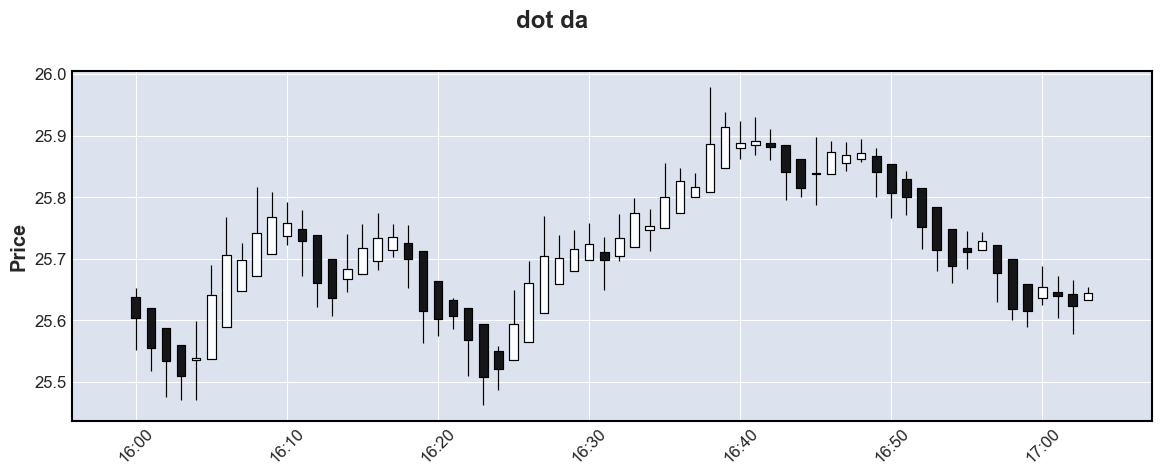

In [47]:
mpf.plot(da.head(150), type='candle', volume=False, title='dot da', figsize=(15, 5))

In [220]:
de

,Open,High,Low,Close
2021-09-20 08:00:00,30.630,30.730,30.545,30.63375
2021-09-20 08:03:00,30.679,30.800,30.460,30.65325
2021-09-20 08:06:00,30.579,30.829,30.570,30.74175
2021-09-20 08:09:00,30.773,30.996,30.773,30.85300
2021-09-20 08:12:00,30.799,30.951,30.718,30.80600
...,...,...,...,...
2021-10-03 00:48:00,31.945,31.945,31.153,31.42650
2021-10-03 00:51:00,31.596,31.600,31.279,31.44475
2021-10-03 00:54:00,31.304,31.646,31.304,31.55700
2021-10-03 00:57:00,31.595,31.648,31.497,31.55525


In [203]:
serie = de.Close

In [10]:
# plt.style.available

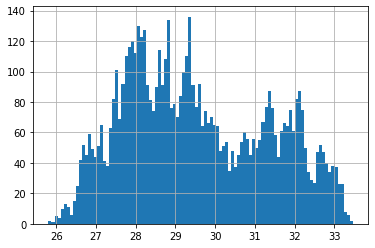

In [204]:
plt.style.use('_classic_test_patch')
plt.hist(serie, bins=100)
plt.grid()

In [205]:
len(serie)

6101

In [212]:
A, B = np.histogram(serie, bins=75)
Q = []
for i, n in enumerate(A):
    # if n>1:
    # print(n, round(B[i], 2), end="|")    
    Q.append([n, B[i]])

total = np.array(Q)[:, 0].sum()
print('total:', total)
print()
Q2 = []
for i, q in enumerate(Q):
    if q[0]>total*.019:
        print(i, round(q[-1], 2), end="|")
        Q2.append(q[-1])
len(Q), len(Q2)

total: 6101.0

16 27.44|18 27.64|19 27.74|20 27.85|21 27.95|22 28.05|23 28.15|24 28.25|27 28.56|28 28.66|29 28.77|33 29.17|34 29.28|35 29.38|54 31.32|61 32.03|

(75, 16)

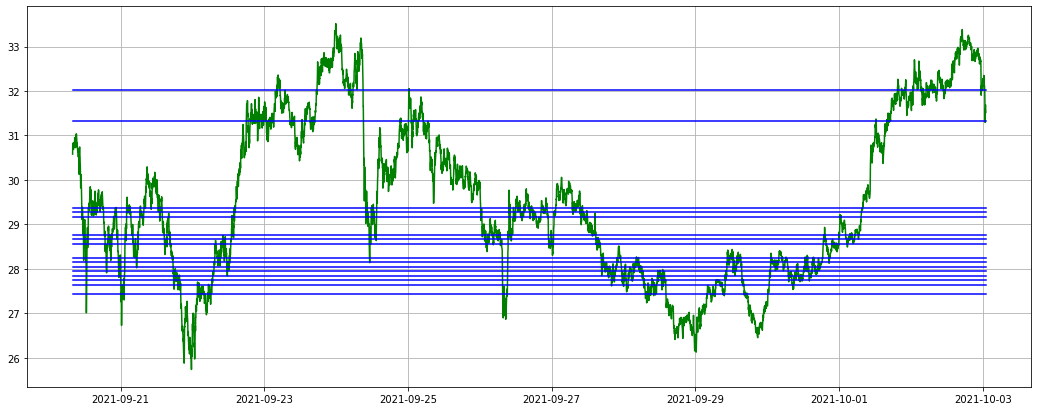

In [213]:
plt.figure(figsize=(18, 7))
# plt.plot(index, SS, ".", c='green')
plt.plot(index, SS, c='green')
for q in Q2:
    plt.plot([index[0], index[-1]], [q, q], c='b')
plt.grid()
plt.show()

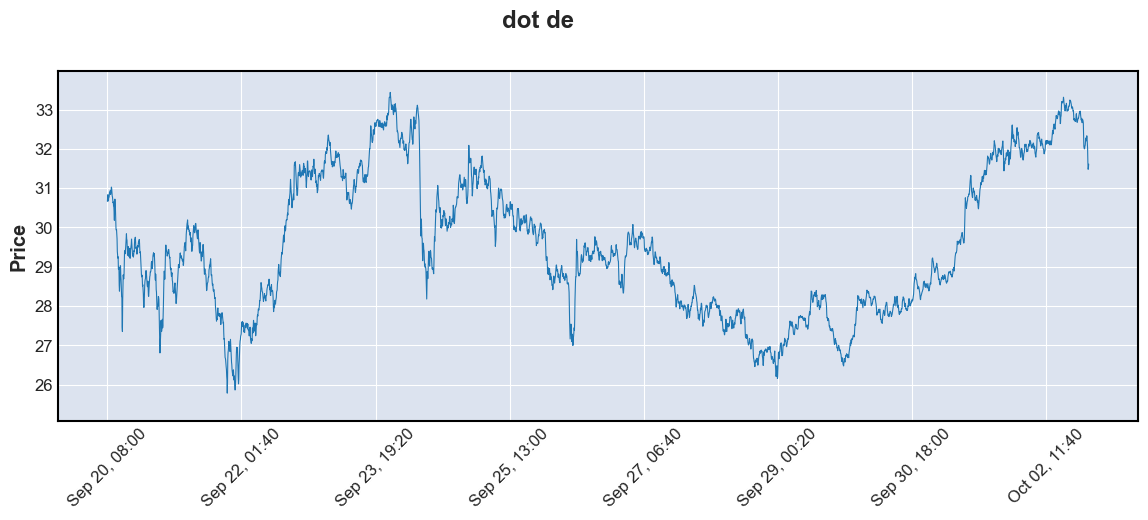

In [25]:
mpf.plot(de, type='line', volume=False, title='dot de', figsize=(15, 5))

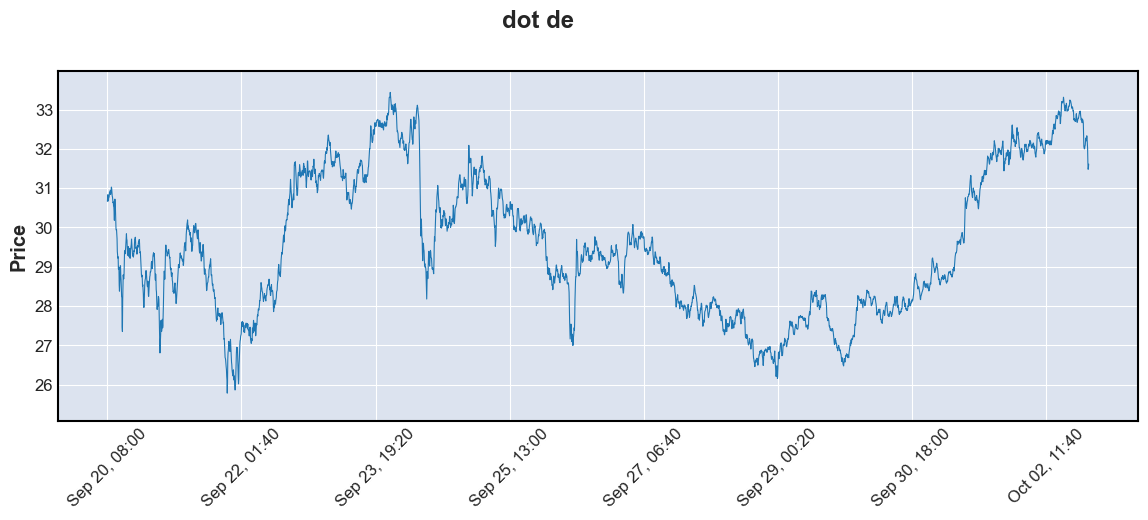

In [28]:
mpf.plot(de, type='line', volume=False, title='dot de', figsize=(15, 5))